# Base Models

LA Transformer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.nn import init

def weights_init_kaiming(m):
    """
    Initialization of weights of the model layers 
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in') # For old pytorch, you may use kaiming_normal.
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_classifier(m):
    """
    Initialization of the classifier head wts of the model
    """
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal_(m.weight.data, std=0.001)
        init.constant_(m.bias.data, 0.0)
        
class ClassBlock(nn.Module):
    """
    loclly aware network structure
    """
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, num_bottleneck=512, linear=True, return_f = False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear:
            add_block += [nn.Linear(input_dim, num_bottleneck)]
        else:
            num_bottleneck = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate>0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
    def forward(self, x):
        x = self.add_block(x)
        if self.return_f:
            f = x
            x = self.classifier(x)
            return [x,f]
        else:
            x = self.classifier(x)
            return x
        
class LATransformer(nn.Module):
    """
    The main model architecture
    Here the "model" param in __init__ is the ViT backbone
    """
    def __init__(self, model, lmbd, class_num,part,num_blocks,int_dim ):
        super(LATransformer, self).__init__()
        self.class_num = class_num
        self.part = part # We cut the pool5 to sqrt(N) parts
        self.num_blocks = num_blocks
        self.model = model
        self.model.head.requires_grad_ = False 
        self.cls_token = self.model.cls_token
        self.pos_embed = self.model.pos_embed
        self.avgpool = nn.AdaptiveAvgPool2d((self.part,int_dim))
        self.dropout = nn.Dropout(p=0.5)
        self.lmbd = lmbd
        for i in range(self.part):
            name = 'classifier'+str(i)
            setattr(self, name, ClassBlock(int_dim, self.class_num, droprate=0.5, relu=False, bnorm=True, num_bottleneck=256))

        

    def forward(self,x):
        
        # Divide input image into patch embeddings and add position embeddings
        x = self.model.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) 
        x = torch.cat((cls_token, x), dim=1)
        x = self.model.pos_drop(x + self.pos_embed)
        
        # Feed forward through transformer blocks
        for i in range(self.num_blocks):
            x = self.model.blocks[i](x)
        x = self.model.norm(x)
        
        # extract the cls token
        cls_token_out = x[:, 0].unsqueeze(1)
        
        # Average pool
        x = self.avgpool(x[:, 1:])
        
        # Add global cls token to each local token 
        for i in range(self.part):
            out = torch.mul(x[:, i, :], self.lmbd)
            x[:,i,:] = torch.div(torch.add(cls_token_out.squeeze(),out), 1+self.lmbd)
        
        # Locally aware network
        part = {}
        predict = {}
        for i in range(self.part):
            part[i] = x[:,i,:]
            name = 'classifier'+str(i)
            c = getattr(self,name)
            predict[i] = c(part[i])
        return predict


# Softmax Loss

###Training

In [ ]:
import os
import time
import random

!pip install timm
import timm
import numpy as np
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def set_seed(seed):
    """
    This method helps to seed the libraries, it is important to get reproducible results
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
def train_one_epoch(epoch, model, loader, optimizer, loss_fn,verbose=False):
    """
    This method implements training of model for one epoch
    """
    
    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()

    model.train()
    epoch_accuracy = 0
    epoch_loss = 0
    end = time.time()

    for index,(data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        data_time_m.update(time.time() - end)

        optimizer.zero_grad()
        output = model(data)
        score = 0.0
        sm = nn.Softmax(dim=1)
        for k, v in output.items():
            score += sm(output[k])
        _, preds = torch.max(score.data, 1)
        
        loss = 0.0
        for k,v in output.items():
            loss += loss_fn(output[k], target)
        loss.backward()

        optimizer.step()

        batch_time_m.update(time.time() - end)
        acc = (preds == target.data).float().mean()

        epoch_loss += loss/len(loader)
        epoch_accuracy += acc / len(loader)

    if verbose:
        print("The loss at epoch "+str(epoch)+ " was "+str(epoch_loss.data.item())+ " and the training accuracy is "+str(epoch_accuracy.data.item()))

    return OrderedDict([('train_loss', epoch_loss.data.item()), ("train_accuracy", epoch_accuracy.data.item())])

In [ ]:
def visualization(loss_arr,epo,loss):
  """
  This is to visualize the training curves
  """
  x = np.linspace(1,epo,epo)
  if loss:
      plt.plot(x,loss_arr, label='Training Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epochs')
      plt.title('Training Curve')
  else:
      plt.plot(x,loss_arr, label='Training Accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epochs')
      plt.title('Training Curve')
  
  plt.legend()
  plt.show()

In [ ]:
def training(model,optimizer,criterion,scheduler,num_epochs,verbose,blocks,unfreeze_after,train_loader):
    """
    Simulates the training of model
    """
    unfrozen_blocks = 0
    train_loss=[]
    train_accuracy=[]
    
    for epoch in range(num_epochs):
        if epoch%unfreeze_after==0:
            unfrozen_blocks += 1
            model = unfreeze_blocks(model,blocks, unfrozen_blocks)
            optimizer.param_groups[0]['lr'] *= lr_decay 
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print("Unfrozen Blocks: {}, Current lr: {}, Trainable Params: {}".format(unfrozen_blocks, 
                                                                                 optimizer.param_groups[0]['lr'], 
                                                                                 trainable_params))
    
        train_metrics = train_one_epoch(epoch, model, train_loader, optimizer, criterion,verbose=verbose)
        train_loss.append(train_metrics["train_loss"])
        train_accuracy.append(train_metrics["train_accuracy"])
    
    visualization(train_loss, num_epochs, True)
    visualization(train_accuracy, num_epochs, False)
    
    return model

In [ ]:
def freeze_all_blocks(model,blocks):
    """
    This method is used to freeze all 12[as per the original publication] blocks of a ViT
    """
    frozen_blocks = blocks
    for block in model.model.blocks[:frozen_blocks]:
        for param in block.parameters():
            param.requires_grad=False
            
            
def unfreeze_blocks(model, blocks, amount= 1):
    """
    This method is used to unfreeze some blocks
    """
    for block in model.model.blocks[(blocks-1)-amount:]:
        for param in block.parameters():
            param.requires_grad=True
    return model

In [ ]:
inp_path ="/content/drive/MyDrive/vision_project_data"
out_path = "output.pth"
num_classes = 62

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {}".format(device))
set_seed(0)

Using cuda


In [ ]:
batch_size = 32
num_epochs = 30
lr = 3e-4
gamma = 0.7
unfreeze_after=2
lr_decay=.8
lmbd = 8

In [ ]:
transform_train_list = [
transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BICUBIC),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
    
    
data_transforms = {
'train': transforms.Compose( transform_train_list )
}

In [ ]:
image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(inp_path, 'train'),
                                      data_transforms['train'])

train_loader = DataLoader(dataset = image_datasets['train'], batch_size=batch_size, shuffle=True )


In [ ]:
"""
Setting up model and training
"""
# Create LA Transformer
vit_base = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
vit_base= vit_base.to(device)
vit_base.eval()
num_la_blocks = 14
blocks = 12
int_dim = 768
model = LATransformer(vit_base, lmbd,num_classes,num_la_blocks,blocks,int_dim).to(device)
print(model.eval())

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(),weight_decay=5e-4, lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
freeze_all_blocks(model,blocks)


LATransformer(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
      

Training Begins...
Unfrozen Blocks: 1, Current lr: 0.00023999999999999998, Trainable Params: 17953954
The loss at epoch 0 was 56.558860778808594 and the training accuracy is 0.2641128897666931
The loss at epoch 1 was 50.52006149291992 and the training accuracy is 0.6250000596046448
Unfrozen Blocks: 2, Current lr: 0.000192, Trainable Params: 25041826
The loss at epoch 2 was 44.12189483642578 and the training accuracy is 0.7620967030525208
The loss at epoch 3 was 38.5203857421875 and the training accuracy is 0.8518145084381104
Unfrozen Blocks: 3, Current lr: 0.00015360000000000002, Trainable Params: 32129698
The loss at epoch 4 was 33.60707473754883 and the training accuracy is 0.9133062362670898
The loss at epoch 5 was 29.26893424987793 and the training accuracy is 0.9445563554763794
Unfrozen Blocks: 4, Current lr: 0.00012288000000000002, Trainable Params: 39217570
The loss at epoch 6 was 25.79910659790039 and the training accuracy is 0.9495967030525208
The loss at epoch 7 was 22.561059

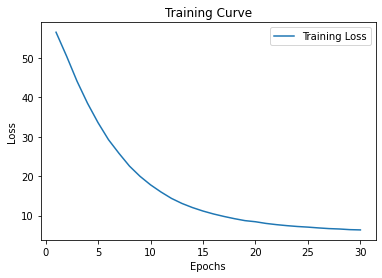

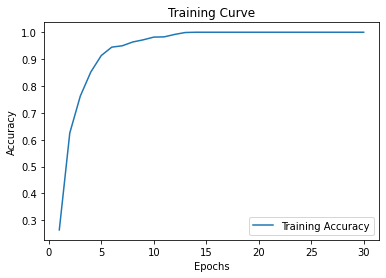

Training Completed


In [ ]:
"""
Training Begins
"""

print("Training Begins...")
model = training(model,optimizer,criterion,scheduler,num_epochs,True,blocks,unfreeze_after,train_loader)
print("Training Completed")
torch.save(model.cpu().state_dict(), out_path)

###Testing

In [3]:
def get_id(img_path):
    camera_id = []
    labels = []
    for path, v in img_path:
        label = path.split("/")[-2]
        filename = os.path.basename(path)
        camera = filename.split('_')[0]
        labels.append(int(label))
        camera_id.append(int(camera))
    return camera_id, labels

In [4]:
def extract_feature(model,dataloaders,device,image_dataset):
    """
    Used to get the features/representation of queryset and galleryset
    """
    features =  torch.FloatTensor()
    count = 0
    idx = 0
    images= {}
    for index,data in enumerate(dataloaders):
        img, label = data    
        img, label = img.to(device), label.to(device)

        output = model(img) # (B, D, H, W) --> B: batch size, HxWxD: feature volume size

        n, c, h, w = img.size()
        
        count += n
        features = torch.cat((features, output.detach().cpu()), 0)
        idx += 1
        images[index]=image_dataset.imgs[index][0]
    return features,images

def search(index,query: str, k=1):
    """
    to do a similarity based search using faiss library
    """
    encoded_query = query.unsqueeze(dim=0).numpy()
    top_k = index.search(encoded_query, k)
    return top_k

In [5]:
def rank1(label, output):
    if label==output[1][0][0]:
        return True
    return False

def rank5(label, output):
    if label in output[1][0][:5]:
        return True
    return False

def calc_ap(label, output):
    count = 0
    score = 0
    good = 0
    for out in output[1][0]:
        count += 1
        if out==label:
            good += 1            
            score += (good/count)
    if good==0:
        return 0
    return score/good

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {}".format(device))

Using cpu


In [8]:
import os
!pip install faiss-gpu
import faiss
import numpy as np

import argparse
!pip install timm
import timm
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

     |████████████████████████████████| 376 kB 7.0 MB/s 


In [9]:
wts_path = "/content/drive/MyDrive/vision_project_data/base_output.pth"
inp_path ="/content/drive/MyDrive/vision_project_data/val"

In [10]:
class LATransformerTest(nn.Module):
    def __init__(self, model, lmbd, class_num,part,num_blocks,int_dim ):
        super(LATransformerTest, self).__init__()
        
        self.class_num = class_num
        self.part = part # We cut the pool5 to sqrt(N) parts
        self.num_blocks = num_blocks
        self.model = model
        self.model.head.requires_grad_ = False 
        self.cls_token = self.model.cls_token
        self.pos_embed = self.model.pos_embed
        self.avgpool = nn.AdaptiveAvgPool2d((self.part,int_dim))
        self.dropout = nn.Dropout(p=0.5)
        self.lmbd = lmbd
#         for i in range(self.part):
#             name = 'classifier'+str(i)
#             setattr(self, name, ClassBlock(768, self.class_num, droprate=0.5, relu=False, bnorm=True, num_bottleneck=256))

        

    def forward(self,x):
        
        # Divide input image into patch embeddings and add position embeddings
        x = self.model.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) 
        x = torch.cat((cls_token, x), dim=1)
        x = self.model.pos_drop(x + self.pos_embed)
        
        # Feed forward through transformer blocks
        for i in range(self.num_blocks):
            x = self.model.blocks[i](x)
        x = self.model.norm(x)
        
        # extract the cls token
        cls_token_out = x[:, 0].unsqueeze(1)
        
        # Average pool
        x = self.avgpool(x[:, 1:])
        
        # Add global cls token to each local token 
#         for i in range(self.part):
#             out = torch.mul(x[:, i, :], self.lmbd)
#             x[:,i,:] = torch.div(torch.add(cls_token_out.squeeze(),out), 1+self.lmbd)

        return x.cpu()

In [11]:
"""
Load saved model
"""
num_classes = 62
vit_base = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
vit_base= vit_base.to(device)

# Create La-Transformer

num_la_blocks = 14
blocks = 12
int_dim = 768
lmbd = 8
num_classes = 62
model = LATransformerTest(vit_base, lmbd,num_classes,num_la_blocks,blocks,int_dim).to(device)
model.load_state_dict(torch.load(wts_path), strict=False)
model.eval()

LATransformerTest(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
  

In [12]:
batch_size = 1

In [13]:
transform_query_list = [
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
transform_gallery_list = [
        transforms.Resize(size=(224,224), interpolation=transforms.InterpolationMode.BICUBIC), #Image.BICUBIC
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]

data_transforms = {
        'query': transforms.Compose( transform_query_list ),
        'gallery': transforms.Compose(transform_gallery_list),
    }


image_datasets = {}

image_datasets['query'] = datasets.ImageFolder(os.path.join(inp_path, 'query'),
                                          data_transforms['query'])
image_datasets['gallery'] = datasets.ImageFolder(os.path.join(inp_path, 'gallery'),
                                          data_transforms['gallery'])
query_loader = DataLoader(dataset = image_datasets['query'], batch_size=batch_size, shuffle=False )
gallery_loader = DataLoader(dataset = image_datasets['gallery'], batch_size=batch_size, shuffle=False)


In [14]:
# Extract Query Features

query_feature,query_images= extract_feature(model,query_loader,device,image_datasets['query'])

# Extract Gallery Features

gallery_feature,gallery_images = extract_feature(model,gallery_loader,device,image_datasets['gallery'])

# Retrieve labels



In [15]:
gallery_path = image_datasets['gallery'].imgs
query_path = image_datasets['query'].imgs

gallery_cam,gallery_label = get_id(gallery_path)
query_cam,query_label = get_id(query_path)

In [16]:
concatenated_query_vectors = []
for idx,query in enumerate(query_feature):
    fnorm = torch.norm(query, p=2, dim=1, keepdim=True)*np.sqrt(14)
    query_norm = query.div(fnorm.expand_as(query))
    concatenated_query_vectors.append(query_norm.view((-1)))

concatenated_gallery_vectors = []
for idx,gallery in enumerate(gallery_feature):
    fnorm = torch.norm(gallery, p=2, dim=1, keepdim=True)*np.sqrt(14)
    gallery_norm = gallery.div(fnorm.expand_as(gallery))
    concatenated_gallery_vectors.append(gallery_norm.view((-1)))

In [17]:
index = faiss.IndexIDMap(faiss.IndexFlatIP(10752))
index.add_with_ids(np.array([t.numpy() for t in concatenated_gallery_vectors]),np.array(gallery_label).astype(np.int64))

index2 = (faiss.IndexFlatIP((14*768)))
index2.add(np.array([t.numpy() for t in concatenated_gallery_vectors]))

In [ ]:
from shutil import copyfile
import os
vis_path = "/content/drive/MyDrive/vision_project_data/visualisation"
mod_str = "baseline"

In [21]:
rank1_score = 0
rank5_score = 0
ap = 0
itr_no = 0
count = 0
for query, label in zip(concatenated_query_vectors, query_label):
    count +=1
    label = label
    output_met = search(index,query, k=10)

    encoded_query = query.unsqueeze(dim=0).numpy()

    output = index.search(encoded_query,10)
    output2 = index2.search(encoded_query,10)
    label_pred = output[1][0][0]

    rank1_score += rank1(label, output_met) 
    rank5_score += rank5(label, output_met) 
    print("Correct: {}, Total: {}, Incorrect: {}".format(rank1_score, count, count-rank1_score))
    ap += calc_ap(label, output)

    list_preds = output2[1]
    pred_img = gallery_images[list_preds[0][0]]
    pred_img2 = gallery_images[list_preds[0][1]]
    pred_img3 = gallery_images[list_preds[0][2]]
    pred_img4 = gallery_images[list_preds[0][3]]
    pred_img5 = gallery_images[list_preds[0][4]]
    pred_img6 = gallery_images[list_preds[0][5]]
    pred_img7 = gallery_images[list_preds[0][6]]
    pred_img8 = gallery_images[list_preds[0][7]]
    pred_img9 = gallery_images[list_preds[0][8]]
    pred_img10 = gallery_images[list_preds[0][9]]
    inp_img = query_images[itr_no]
    
    if os.path.exists(vis_path+'/'+mod_str+'_'+str(count)):
      shutil.rmtree(vis_path+'/'+mod_str+'_'+str(count))
    os.mkdir(vis_path+'/'+mod_str+'_'+str(count))

    copyfile(inp_img, vis_path+'/'+mod_str+'_'+str(count)+'/query'+'.png')
    copyfile(pred_img, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'1'+'.png')
    copyfile(pred_img2, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'2'+'.png')
    copyfile(pred_img3, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'3'+'.png')
    copyfile(pred_img4, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'4'+'.png')
    copyfile(pred_img5, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'5'+'.png')
    copyfile(pred_img6, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'6'+'.png')
    copyfile(pred_img7, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'7'+'.png')
    copyfile(pred_img8, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'8'+'.png')
    copyfile(pred_img9, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'9'+'.png')
    copyfile(pred_img10, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'10'+'.png')
    itr_no +=1

print("Rank1: %.3f, Rank5: %.3f, mAP: %.3f"%(rank1_score/len(query_feature), 
                                              rank5_score/len(query_feature), 
                                              ap/len(query_feature)))  

Correct: 1, Total: 1, Incorrect: 0
Correct: 2, Total: 2, Incorrect: 0
Correct: 3, Total: 3, Incorrect: 0
Correct: 4, Total: 4, Incorrect: 0
Correct: 5, Total: 5, Incorrect: 0
Correct: 6, Total: 6, Incorrect: 0
Correct: 7, Total: 7, Incorrect: 0
Correct: 8, Total: 8, Incorrect: 0
Correct: 9, Total: 9, Incorrect: 0
Correct: 10, Total: 10, Incorrect: 0
Correct: 11, Total: 11, Incorrect: 0
Correct: 12, Total: 12, Incorrect: 0
Correct: 13, Total: 13, Incorrect: 0
Correct: 14, Total: 14, Incorrect: 0
Correct: 15, Total: 15, Incorrect: 0
Correct: 16, Total: 16, Incorrect: 0
Correct: 17, Total: 17, Incorrect: 0
Correct: 18, Total: 18, Incorrect: 0
Correct: 19, Total: 19, Incorrect: 0
Correct: 20, Total: 20, Incorrect: 0
Correct: 21, Total: 21, Incorrect: 0
Correct: 22, Total: 22, Incorrect: 0
Correct: 22, Total: 23, Incorrect: 1
Correct: 22, Total: 24, Incorrect: 2
Correct: 23, Total: 25, Incorrect: 2
Correct: 24, Total: 26, Incorrect: 2
Correct: 25, Total: 27, Incorrect: 2
Correct: 26, Total:

# Pooling(x+y) with AMS + Triplet Loss + Flip

In [31]:
import torch
import torch.nn as nn
from torch.nn import init

def weights_init_kaiming(m):
    """
    Initialization of weights of the model layers 
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in') # For old pytorch, you may use kaiming_normal.
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_classifier(m):
    """
    Initialization of the classifier head wts of the model
    """
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal_(m.weight.data, std=0.001)
        init.constant_(m.bias.data, 0.0)
        
class ClassBlock(nn.Module):
    """
    loclly aware network structure
    """
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, num_bottleneck=512, linear=True, return_f = False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear:
            add_block += [nn.Linear(input_dim, num_bottleneck)]
        else:
            num_bottleneck = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate>0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
    def forward(self, x):
        x = self.add_block(x)
        if self.return_f:
            f = x
            x = self.classifier(x)
            return [x,f]
        else:
            x = self.classifier(x)
            return x

In [32]:
class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
    Reference:
    Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    Code imported from https://github.com/Cysu/open-reid/blob/master/reid/loss/triplet.py.
    Args:
        margin (float): margin for triplet.
    """
    def __init__(self, margin=0.3, mutual_flag = False):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)
        self.mutual = mutual_flag

    def forward(self, inputs, targets):
        """
        Args:
            inputs: feature matrix with shape (batch_size, feat_dim)
            targets: ground truth labels with shape (num_classes)
        """
        n = inputs.size(0)
        # inputs = 1. * inputs / (torch.norm(inputs, 2, dim=-1, keepdim=True).expand_as(inputs) + 1e-12)
        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
        # For each anchor, find the hardest positive and negative
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            dist_ap.append(dist[i][mask[i]].max().unsqueeze(0))
            dist_an.append(dist[i][mask[i] == 0].min().unsqueeze(0))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        # Compute ranking hinge loss
        y = torch.ones_like(dist_an)
        loss = self.ranking_loss(dist_an, dist_ap, y)
        if self.mutual:
            return loss, dist
        return loss

In [33]:
class LATransformer_AMSpoolsumtriplet(nn.Module):
    """
    The main model architecture
    Here the "model" param in __init__ is the ViT backbone
    """
    def __init__(self, model, lmbd, class_num,part,num_blocks,int_dim ):
        super(LATransformer_AMSpoolsumtriplet, self).__init__()
        self.class_num = class_num
        self.part = part # We cut the pool5 to sqrt(N) parts
        self.num_blocks = num_blocks
        self.model = model
        self.model.head.requires_grad_ = False 
        self.cls_token = self.model.cls_token
        self.pos_embed = self.model.pos_embed
        self.avgpool2 = nn.AdaptiveAvgPool2d((self.part,int_dim))
        self.avgpool = nn.AdaptiveAvgPool2d((1,int_dim))
        self.dropout = nn.Dropout(p=0.5)
        self.lmbd = lmbd
        self.int_dim = int_dim
        for i in range(self.part):
            name = 'classifier'+str(i)
            setattr(self, name, ClassBlock(int_dim, self.class_num, droprate=0.5, relu=False, bnorm=True, num_bottleneck=256,return_f=True))

        

    def forward(self,x):
        
        # Divide input image into patch embeddings and add position embeddings
        x = self.model.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) 
        x = torch.cat((cls_token, x), dim=1)
        x = self.model.pos_drop(x + self.pos_embed)
        
        # Feed forward through transformer blocks
        for i in range(self.num_blocks):
            x = self.model.blocks[i](x)
        x = self.model.norm(x)
        
        # extract the cls token
        cls_token_out = x[:, 0].unsqueeze(1)
        
        # Average pool
        x2= x.detach().clone()
        x2 = self.avgpool2(x2)
        x = torch.reshape(x[:,1:],(x.shape[0],self.part,self.part,self.int_dim))
        x = self.avgpool(x)
        x = torch.reshape(x,(x.shape[0],self.part,self.int_dim))
        x = (x+x2)/2
        
        # Add global cls token to each local token 
        for i in range(self.part):
            out = torch.mul(x[:, i, :], self.lmbd)
            x[:,i,:] = torch.div(torch.add(cls_token_out.squeeze(),out), 1+self.lmbd)
        
        # Locally aware network
        part = {}
        predict = {}
        pred = {}
        pred_classes = {}
        for i in range(self.part):
            part[i] = x[:,i,:]
            name = 'classifier'+str(i)
            c = getattr(self,name)
            temp = c(part[i])
            predict[i] = temp[1]
            pred[i] = temp[0]
            pred_classes[i] = temp[0]
        return (pred,predict,pred_classes)

In [34]:
class AM_Softmax(nn.Module): #requires classification layer for normalization 
    def __init__(self, m=0.35, s=30, d=2048, num_classes=625, use_gpu=True , epsilon=0.1,smoothing=True):
        super(AM_Softmax, self).__init__()
        self.m = m
        self.s = s 
        self.num_classes = num_classes
        self.CrossEntropy = CrossEntropyLabelSmooth(self.num_classes , use_gpu=use_gpu)
        self.smoothing = smoothing

    def forward(self, features, labels , classifier  ):
        '''
        x : feature vector : (b x  d) b= batch size d = dimension 
        labels : (b,)
        classifier : Fully Connected weights of classification layer (dxC), C is the number of classes: represents the vectors for class, assumed to be an object of nn.sequential
        '''
        features = nn.functional.normalize(features, p=2, dim=1) # normalize the features
        with torch.no_grad():
            classifier[0].weight=nn.Parameter(classifier[0].weight.div(torch.norm(classifier[0].weight, dim=1, keepdim=True)))  ## [0] bracing as assumed to be from nn.sequential

        cos_angle = classifier(features)
        cos_angle = torch.clamp( cos_angle , min = -1 , max = 1 ) 
        b = features.size(0)
        for i in range(b):
            cos_angle[i][labels[i]] = cos_angle[i][labels[i]]  - self.m 
        weighted_cos_angle = self.s * cos_angle
        log_probs = self.CrossEntropy(weighted_cos_angle , labels, use_label_smoothing=self.smoothing)
        return log_probs

In [35]:
class CrossEntropyLabelSmooth(nn.Module):
    """Cross entropy loss with label smoothing regularizer.
    Reference:
    Szegedy et al. Rethinking the Inception Architecture for Computer Vision. CVPR 2016.
    Equation: y = (1 - epsilon) * y + epsilon / K.
    Args:
        num_classes (int): number of classes.
        epsilon (float): weight.
    """

    def __init__(self, num_classes, epsilon=0.1, use_gpu=True):
        super(CrossEntropyLabelSmooth, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.use_gpu = use_gpu
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, targets, use_label_smoothing=True):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (batch_size, num_classes)
            targets: ground truth labels with shape (batch_size,)
        """
        log_probs = self.logsoftmax(inputs)
        targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).data.cpu(), 1)
        if self.use_gpu: targets = targets.to(torch.device('cuda'))
        if use_label_smoothing:
            targets = (1 - self.epsilon) * targets + self.epsilon / self.num_classes
        loss = (- targets * log_probs).mean(0).sum()
        return loss

###Training

In [ ]:
import os
import time
import random

!pip install timm
import timm
import numpy as np
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

     |████████████████████████████████| 376 kB 10.0 MB/s 


In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def set_seed(seed):
    """
    This method helps to seed the libraries, it is important to get reproducible results
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
def train_one_epoch_AMS_triplet(epoch, model, loader, optimizer, loss_fn,loss2,verbose=False):
    """
    This method implements training of model for one epoch with AM Softmax loss function
    """
    
    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()

    model.train()
    epoch_accuracy = 0
    epoch_loss = 0
    end = time.time()

    for index,(data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        data_time_m.update(time.time() - end)

        optimizer.zero_grad()
        (pred,output,classes) = model(data)
        score = 0.0
        sm = nn.Softmax(dim=1)
        for k, v in classes.items():
            score += sm(classes[k])
        _, preds = torch.max(score.data, 1)
        
        loss = 0.0
        for k,v in output.items():
            name = 'classifier'+str(k)
            c = getattr(model,name)
            c = getattr(c,'classifier')
            loss += loss_fn(output[k], target,c)
            loss += loss2(pred[k],target)
        loss.backward()

        optimizer.step()

        batch_time_m.update(time.time() - end)
        acc = (preds == target.data).float().mean()

        epoch_loss += loss/len(loader)
        epoch_accuracy += acc / len(loader)

    if verbose:
        print("The loss at epoch "+str(epoch)+ " was "+str(epoch_loss.data.item())+ " and the training accuracy is "+str(epoch_accuracy.data.item()))

    return OrderedDict([('train_loss', epoch_loss.data.item()), ("train_accuracy", epoch_accuracy.data.item())])

In [ ]:
def visualization(loss_arr,epo,loss):
  """
  This is to visualize the training curves
  """
  x = np.linspace(1,epo,epo)
  if loss:
      plt.plot(x,loss_arr, label='Training Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epochs')
      plt.title('Training Curve')
  else:
      plt.plot(x,loss_arr, label='Training Accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epochs')
      plt.title('Training Curve')
  
  plt.legend()
  plt.show()

In [ ]:
def training_AMS_triplet(model,optimizer,criterion,scheduler,num_epochs,verbose,blocks,unfreeze_after,train_loader,loss2):
    """
    Simulates the training of model
    """
    unfrozen_blocks = 0
    train_loss=[]
    train_accuracy=[]
    
    for epoch in range(num_epochs):
        if epoch%unfreeze_after==0:
            unfrozen_blocks += 1
            model = unfreeze_blocks(model,blocks, unfrozen_blocks)
            optimizer.param_groups[0]['lr'] *= lr_decay 
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print("Unfrozen Blocks: {}, Current lr: {}, Trainable Params: {}".format(unfrozen_blocks, 
                                                                                 optimizer.param_groups[0]['lr'], 
                                                                                 trainable_params))
    
        train_metrics = train_one_epoch_AMS_triplet(epoch, model, train_loader, optimizer, criterion,loss2,verbose=verbose)
        train_loss.append(train_metrics["train_loss"])
        train_accuracy.append(train_metrics["train_accuracy"])
    
    visualization(train_loss, num_epochs, True)
    visualization(train_accuracy, num_epochs, False)
    
    return model

In [ ]:
def freeze_all_blocks(model,blocks):
    """
    This method is used to freeze all 12[as per the original publication] blocks of a ViT
    """
    frozen_blocks = blocks
    for block in model.model.blocks[:frozen_blocks]:
        for param in block.parameters():
            param.requires_grad=False
            
            
def unfreeze_blocks(model, blocks, amount= 1):
    """
    This method is used to unfreeze some blocks
    """
    for block in model.model.blocks[(blocks-1)-amount:]:
        for param in block.parameters():
            param.requires_grad=True
    return model

In [ ]:
inp_path ="/content/drive/MyDrive/vision_project_data"
out_path = "/content/drive/MyDrive/vision_project_data/ams_pool_sum_triplet_output.pth"
num_classes = 62

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {}".format(device))
set_seed(0)

Using cuda


In [ ]:
batch_size = 32
num_epochs = 30
lr = 3e-4
gamma = 0.7
unfreeze_after=2
lr_decay=.8
lmbd = 8

In [ ]:
transform_train_list = [
transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BICUBIC),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
    
    
data_transforms = {
'train': transforms.Compose( transform_train_list )
}

In [ ]:
image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(inp_path, 'train'),
                                      data_transforms['train'])

train_loader = DataLoader(dataset = image_datasets['train'], batch_size=batch_size, shuffle=True )


In [ ]:
"""
Setting up model and training
"""
# Create LA Transformer
vit_base = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
vit_base= vit_base.to(device)
vit_base.eval()
num_la_blocks = 14
blocks = 12
int_dim = 768
model = LATransformer_AMSpoolsumtriplet(vit_base, lmbd,num_classes,num_la_blocks,blocks,int_dim).to(device)
print(model.eval())

# loss function
criterion = AM_Softmax(m=0.3,s=15,d=256,num_classes=num_classes,use_gpu=True,epsilon=0.1,smoothing=False)
loss2 = TripletLoss()

# optimizer
optimizer = optim.Adam(model.parameters(),weight_decay=5e-4, lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
freeze_all_blocks(model,blocks)


LATransformer_AMSpoolsumtriplet(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      

Training Begins...
Unfrozen Blocks: 1, Current lr: 0.00023999999999999998, Trainable Params: 17953954
The loss at epoch 0 was 138.71859741210938 and the training accuracy is 0.05040322244167328
The loss at epoch 1 was 123.28632354736328 and the training accuracy is 0.3135080933570862
Unfrozen Blocks: 2, Current lr: 0.000192, Trainable Params: 25041826
The loss at epoch 2 was 112.0887222290039 and the training accuracy is 0.6018145680427551
The loss at epoch 3 was 100.70662689208984 and the training accuracy is 0.7822580337524414
Unfrozen Blocks: 3, Current lr: 0.00015360000000000002, Trainable Params: 32129698
The loss at epoch 4 was 90.1582260131836 and the training accuracy is 0.893144965171814
The loss at epoch 5 was 77.62940979003906 and the training accuracy is 0.9566529989242554
Unfrozen Blocks: 4, Current lr: 0.00012288000000000002, Trainable Params: 39217570
The loss at epoch 6 was 67.12792205810547 and the training accuracy is 0.9798386096954346
The loss at epoch 7 was 57.3213

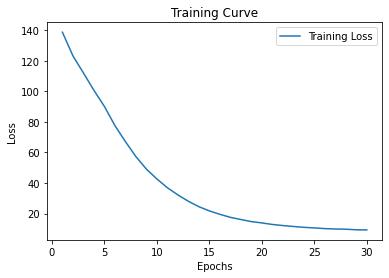

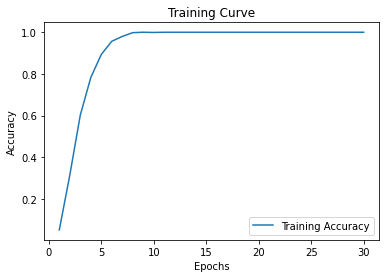

Training Completed


In [ ]:
"""
Training Begins
"""

print("Training Begins...")
model = training_AMS_triplet(model,optimizer,criterion,scheduler,num_epochs,True,blocks,unfreeze_after,train_loader,loss2)
print("Training Completed")
torch.save(model.cpu().state_dict(), out_path)

###Testing

In [36]:
def get_id(img_path):
    camera_id = []
    labels = []
    for path, v in img_path:
        label = path.split("/")[-2]
        filename = os.path.basename(path)
        camera = filename.split('_')[0]
        labels.append(int(label))
        camera_id.append(int(camera))
    return camera_id, labels

In [37]:
def extract_feature(model,dataloaders,device,image_dataset):
    """
    Used to get the features/representation of queryset and galleryset
    """
    features =  torch.FloatTensor()
    count = 0
    idx = 0
    images = {}
    for index,data in enumerate(dataloaders):
        img, label = data    
        img, label = img.to(device), label.to(device)

        img_flip= torch.flip(img,[3])
        output = model(img) # (B, D, H, W) --> B: batch size, HxWxD: feature volume size
        output_flip = model(img_flip)
        output = (output+output_flip)/2

        n, c, h, w = img.size()
        
        count += n
        features = torch.cat((features, output.detach().cpu()), 0)
        idx += 1
        images[index]=image_dataset.imgs[index][0]
    return features,images

def search(index,query: str, k=1):
    """
    to do a similarity based search using faiss library
    """
    encoded_query = query.unsqueeze(dim=0).numpy()
    top_k = index.search(encoded_query, k)
    return top_k

In [38]:
def rank1(label, output):
    if label==output[1][0][0]:
        return True
    return False

def rank5(label, output):
    if label in output[1][0][:5]:
        return True
    return False

def calc_ap(label, output):
    count = 0
    score = 0
    good = 0
    for out in output[1][0]:
        count += 1
        if out==label:
            good += 1            
            score += (good/count)
    if good==0:
        return 0
    return score/good

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {}".format(device))

Using cpu


In [40]:
import os
!pip install faiss-gpu
import faiss
import numpy as np

import argparse
!pip install timm
import timm
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [41]:
wts_path = "/content/drive/MyDrive/vision_project_data/ams_pool_sum_triplet_output.pth"
inp_path ="/content/drive/MyDrive/vision_project_data/val"

In [42]:
class LATransformerTest_Pooldualsum(nn.Module):
    def __init__(self, model, lmbd, class_num,part,num_blocks,int_dim ):
        super(LATransformerTest_Pooldualsum, self).__init__()
        
        self.class_num = class_num
        self.part = part # We cut the pool5 to sqrt(N) parts
        self.num_blocks = num_blocks
        self.model = model
        self.model.head.requires_grad_ = False 
        self.cls_token = self.model.cls_token
        self.pos_embed = self.model.pos_embed
        self.avgpool = nn.AdaptiveAvgPool2d((1,int_dim))
        self.avgpool2 = nn.AdaptiveAvgPool2d((self.part,int_dim))
        self.dropout = nn.Dropout(p=0.5)
        self.lmbd = lmbd
        self.int_dim = int_dim
#         for i in range(self.part):
#             name = 'classifier'+str(i)
#             setattr(self, name, ClassBlock(768, self.class_num, droprate=0.5, relu=False, bnorm=True, num_bottleneck=256))

        

    def forward(self,x):
        
        # Divide input image into patch embeddings and add position embeddings
        x = self.model.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) 
        x = torch.cat((cls_token, x), dim=1)
        x = self.model.pos_drop(x + self.pos_embed)
        
        # Feed forward through transformer blocks
        for i in range(self.num_blocks):
            x = self.model.blocks[i](x)
        x = self.model.norm(x)
        
        # extract the cls token
        cls_token_out = x[:, 0].unsqueeze(1)
        
        # Average pool
        x2= x.detach().clone()
        x2 = self.avgpool2(x2)
        x = torch.reshape(x[:,1:],(x.shape[0],self.part,self.part,self.int_dim))
        x = self.avgpool(x)
        x = torch.reshape(x,(x.shape[0],self.part,self.int_dim))
        x = (x+x2)/2
        
        # Add global cls token to each local token 
#         for i in range(self.part):
#             out = torch.mul(x[:, i, :], self.lmbd)
#             x[:,i,:] = torch.div(torch.add(cls_token_out.squeeze(),out), 1+self.lmbd)

        return x.cpu()

In [43]:
"""
Load saved model
"""
num_classes = 62
vit_base = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
vit_base= vit_base.to(device)

# Create La-Transformer

num_la_blocks = 14
blocks = 12
int_dim = 768
lmbd = 8
num_classes = 62
model = LATransformerTest_Pooldualsum(vit_base, lmbd,num_classes,num_la_blocks,blocks,int_dim).to(device)
model.load_state_dict(torch.load(wts_path), strict=False)
model.eval()

LATransformerTest_Pooldualsum(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1

In [44]:
batch_size = 1

In [45]:
transform_query_list = [
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
transform_gallery_list = [
        transforms.Resize(size=(224,224), interpolation=transforms.InterpolationMode.BICUBIC), #Image.BICUBIC
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]

data_transforms = {
        'query': transforms.Compose( transform_query_list ),
        'gallery': transforms.Compose(transform_gallery_list),
    }


image_datasets = {}

image_datasets['query'] = datasets.ImageFolder(os.path.join(inp_path, 'query'),
                                          data_transforms['query'])
image_datasets['gallery'] = datasets.ImageFolder(os.path.join(inp_path, 'gallery'),
                                          data_transforms['gallery'])
query_loader = DataLoader(dataset = image_datasets['query'], batch_size=batch_size, shuffle=False )
gallery_loader = DataLoader(dataset = image_datasets['gallery'], batch_size=batch_size, shuffle=False)


In [46]:
# Extract Query Features

query_feature,query_images= extract_feature(model,query_loader,device,image_datasets['query'])

# Extract Gallery Features

gallery_feature,gallery_images = extract_feature(model,gallery_loader,device,image_datasets['gallery'])

# Retrieve labels



In [47]:
gallery_path = image_datasets['gallery'].imgs
query_path = image_datasets['query'].imgs

gallery_cam,gallery_label = get_id(gallery_path)
query_cam,query_label = get_id(query_path)

In [48]:
concatenated_query_vectors = []
for idx,query in enumerate(query_feature):
    fnorm = torch.norm(query, p=2, dim=1, keepdim=True)*np.sqrt(14)
    query_norm = query.div(fnorm.expand_as(query))
    concatenated_query_vectors.append(query_norm.view((-1)))

concatenated_gallery_vectors = []
for idx,gallery in enumerate(gallery_feature):
    fnorm = torch.norm(gallery, p=2, dim=1, keepdim=True)*np.sqrt(14)
    gallery_norm = gallery.div(fnorm.expand_as(gallery))
    concatenated_gallery_vectors.append(gallery_norm.view((-1)))

In [49]:
index = faiss.IndexIDMap(faiss.IndexFlatIP(10752))
index.add_with_ids(np.array([t.numpy() for t in concatenated_gallery_vectors]),np.array(gallery_label).astype(np.int64))

index2 = (faiss.IndexFlatIP((14*768)))
index2.add(np.array([t.numpy() for t in concatenated_gallery_vectors]))

In [56]:
from shutil import copyfile
import os
vis_path = "/content/drive/MyDrive/vision_project_data/visualisation"
mod_str = "improved"

In [57]:
rank1_score = 0
rank5_score = 0
ap = 0
itr_no = 0
count = 0
for query, label in zip(concatenated_query_vectors, query_label):
    count +=1
    label = label
    output_met = search(index,query, k=10)

    encoded_query = query.unsqueeze(dim=0).numpy()

    output = index.search(encoded_query,10)
    output2 = index2.search(encoded_query,10)
    label_pred = output[1][0][0]

    rank1_score += rank1(label, output_met) 
    rank5_score += rank5(label, output_met) 
    print("Correct: {}, Total: {}, Incorrect: {}".format(rank1_score, count, count-rank1_score))
    ap += calc_ap(label, output)

    list_preds = output2[1]
    pred_img = gallery_images[list_preds[0][0]]
    pred_img2 = gallery_images[list_preds[0][1]]
    pred_img3 = gallery_images[list_preds[0][2]]
    pred_img4 = gallery_images[list_preds[0][3]]
    pred_img5 = gallery_images[list_preds[0][4]]
    pred_img6 = gallery_images[list_preds[0][5]]
    pred_img7 = gallery_images[list_preds[0][6]]
    pred_img8 = gallery_images[list_preds[0][7]]
    pred_img9 = gallery_images[list_preds[0][8]]
    pred_img10 = gallery_images[list_preds[0][9]]
    inp_img = query_images[itr_no]
    
    if os.path.exists(vis_path+'/'+mod_str+'_'+str(count)):
      shutil.rmtree(vis_path+'/'+mod_str+'_'+str(count))
    os.mkdir(vis_path+'/'+mod_str+'_'+str(count))

    copyfile(inp_img, vis_path+'/'+mod_str+'_'+str(count)+'/query'+'.png')
    copyfile(pred_img, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'1'+'.png')
    copyfile(pred_img2, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'2'+'.png')
    copyfile(pred_img3, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'3'+'.png')
    copyfile(pred_img4, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'4'+'.png')
    copyfile(pred_img5, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'5'+'.png')
    copyfile(pred_img6, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'6'+'.png')
    copyfile(pred_img7, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'7'+'.png')
    copyfile(pred_img8, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'8'+'.png')
    copyfile(pred_img9, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'9'+'.png')
    copyfile(pred_img10, vis_path+'/'+mod_str+'_'+str(count)+'/gallery_'+'10'+'.png')
    itr_no +=1

print("Rank1: %.3f, Rank5: %.3f, mAP: %.3f"%(rank1_score/len(query_feature), 
                                              rank5_score/len(query_feature), 
                                              ap/len(query_feature)))  

Correct: 1, Total: 1, Incorrect: 0
Correct: 2, Total: 2, Incorrect: 0
Correct: 3, Total: 3, Incorrect: 0
Correct: 4, Total: 4, Incorrect: 0
Correct: 5, Total: 5, Incorrect: 0
Correct: 6, Total: 6, Incorrect: 0
Correct: 7, Total: 7, Incorrect: 0
Correct: 8, Total: 8, Incorrect: 0
Correct: 9, Total: 9, Incorrect: 0
Correct: 10, Total: 10, Incorrect: 0
Correct: 11, Total: 11, Incorrect: 0
Correct: 12, Total: 12, Incorrect: 0
Correct: 13, Total: 13, Incorrect: 0
Correct: 14, Total: 14, Incorrect: 0
Correct: 15, Total: 15, Incorrect: 0
Correct: 16, Total: 16, Incorrect: 0
Correct: 17, Total: 17, Incorrect: 0
Correct: 18, Total: 18, Incorrect: 0
Correct: 19, Total: 19, Incorrect: 0
Correct: 20, Total: 20, Incorrect: 0
Correct: 21, Total: 21, Incorrect: 0
Correct: 22, Total: 22, Incorrect: 0
Correct: 23, Total: 23, Incorrect: 0
Correct: 24, Total: 24, Incorrect: 0
Correct: 25, Total: 25, Incorrect: 0
Correct: 26, Total: 26, Incorrect: 0
Correct: 27, Total: 27, Incorrect: 0
Correct: 28, Total: